# <h1><center>TASK A (Churn Classification)</center></h1>
## <center>Goran Živanović (goran@tolstoy.ai, goran@mit.edu)</center>
### <center>March 11, 2025</center>

# Churn Classification

### Customer churn, also known as customer attrition, refers to the loss of clients or subscribers.
### In many industries, including telecommunications, banking, and subscription-based services, retaining existing customers is far more cost-effective than acquiring new ones.
### The goal of this notebook is to analyze customer behavior, identify patterns, and build a machine learning model to predict whether a customer is likely to churn.
### This will help businesses take proactive measures to improve customer retention.

In [82]:
# Import necessary libraries and packages

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

%matplotlib inline

In [84]:
# Load the dataset
# The dataset contains customer behavioral data used to predict churn.

In [85]:
file_path = "./task_data_churned.csv"  # Update this path if needed
df = pd.read_csv(file_path)

# Step 1: Basic Statistical Analysis
### Before preprocessing, we analyze each column:
### - Data type classification (categorical, numerical, etc.)
### - Count and percentage of missing values
### - Basic statistics: mean, std deviation for numerical data
### - Distribution visualization (pie charts for categorical, histograms for numerical)

In [86]:
def basic_statistics(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        missing_count = df[col].isnull().sum()
        missing_percentage = (missing_count / len(df)) * 100
        mean_val = df[col].mean() if col_type in ['int64', 'float64'] else None
        std_dev = df[col].std() if col_type in ['int64', 'float64'] else None
        summary.append([col, col_type, missing_count, missing_percentage, mean_val, std_dev])
    summary_df = pd.DataFrame(summary, columns=['Column', 'Type', 'Missing Count', 'Missing %', 'Mean', 'Std Dev'])
    
    # Visualize categorical columns using pie charts
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set2')
        plt.title(f'Distribution of {col}')
        plt.ylabel('')
        plt.show()
    
    # Visualize numerical columns using histograms
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], bins=20, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    return summary_df

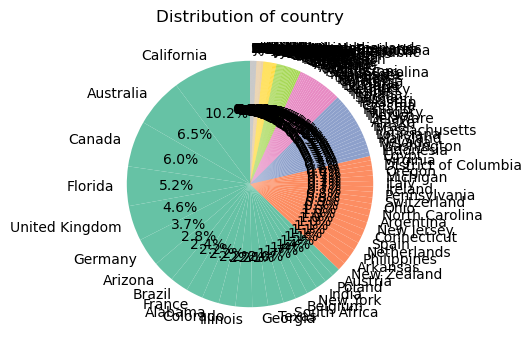

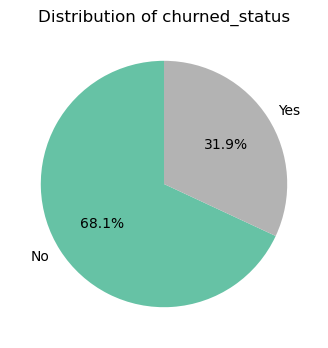

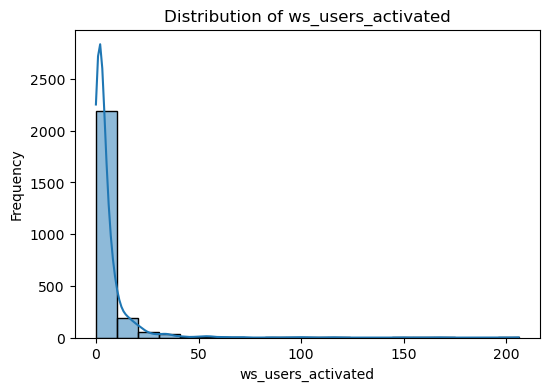

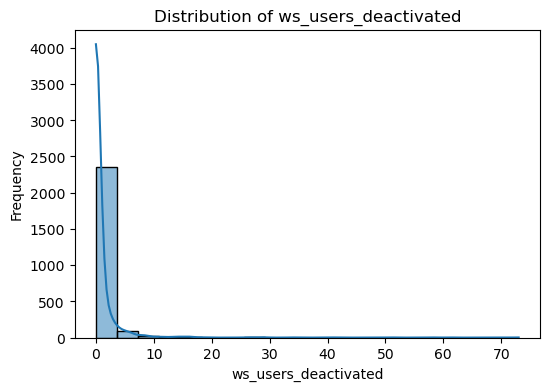

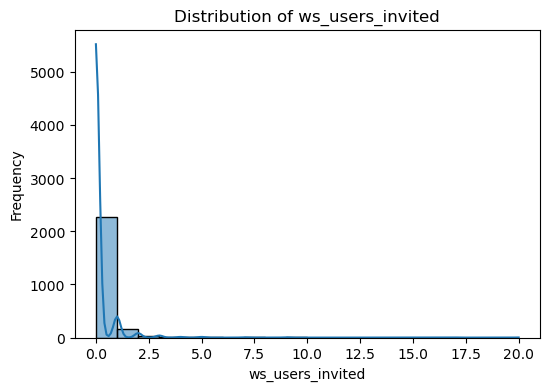

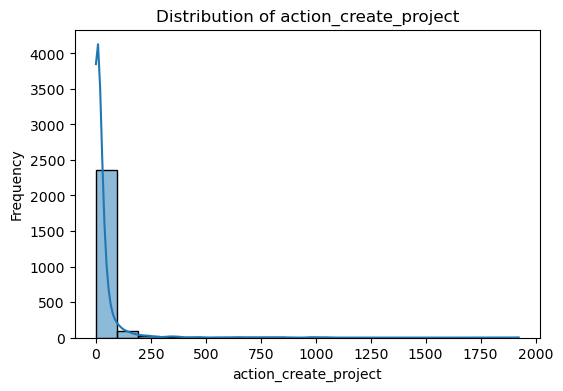

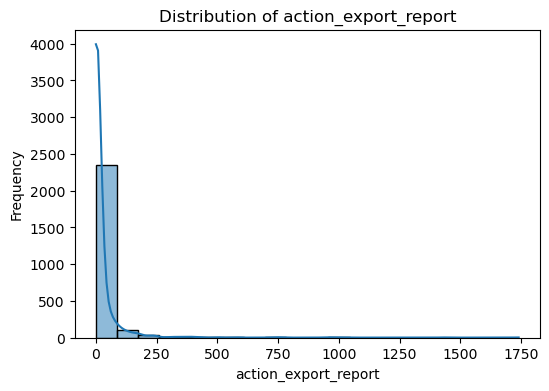

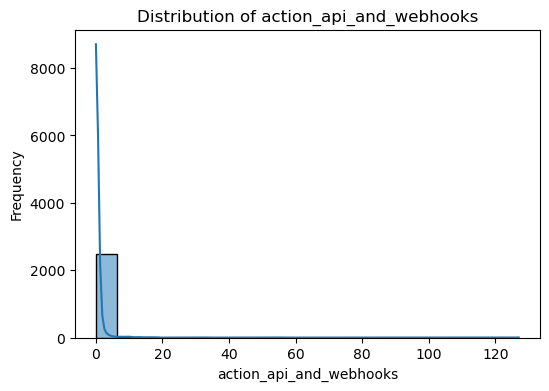

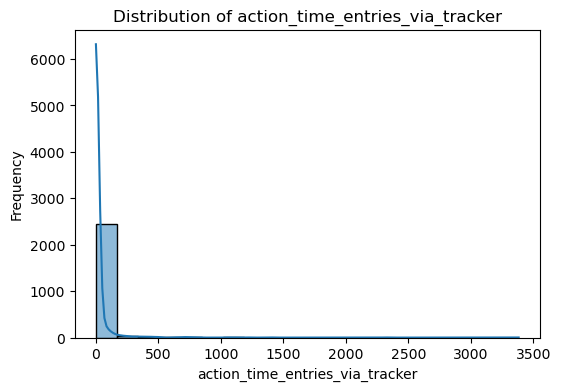

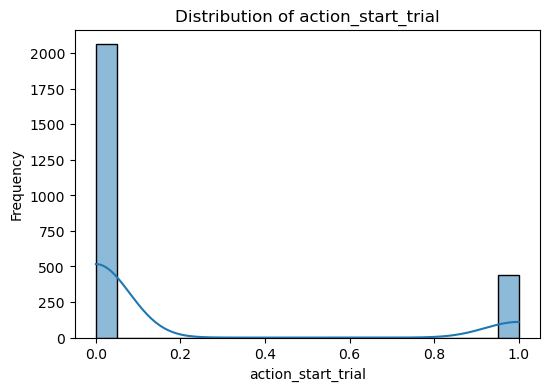

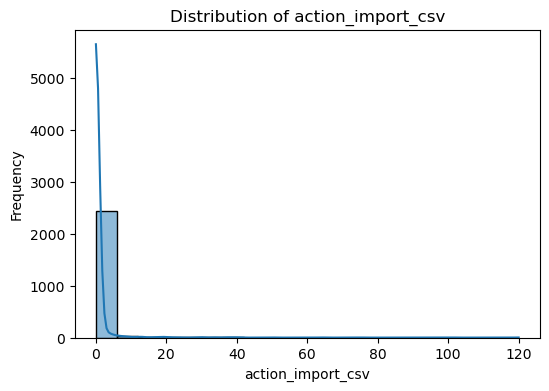

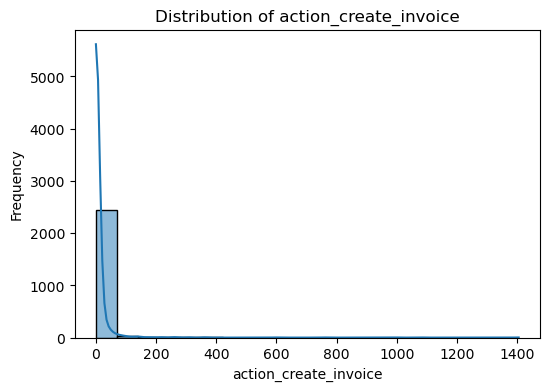

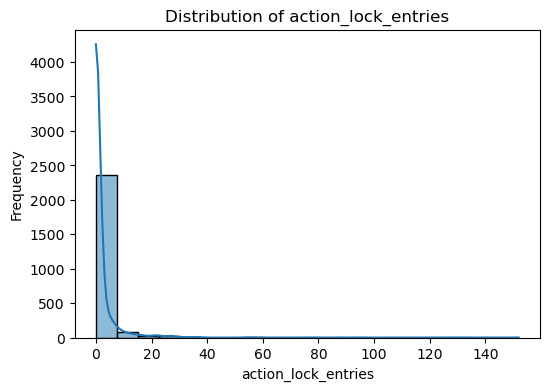

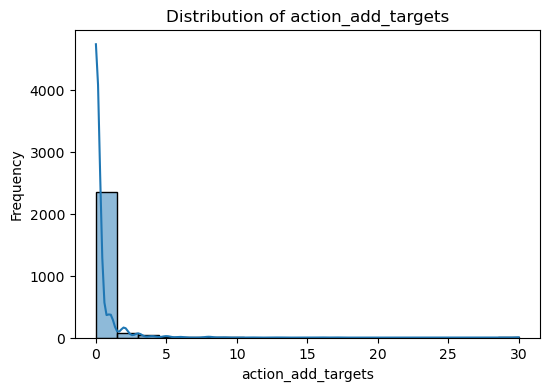

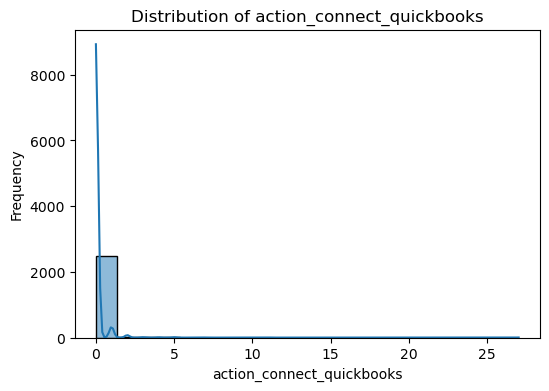

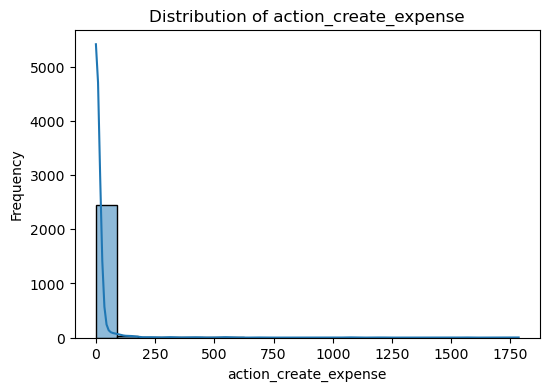

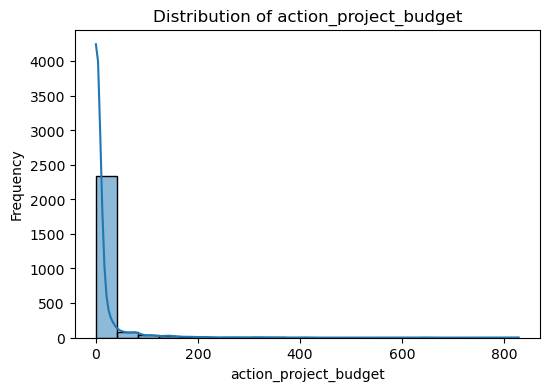

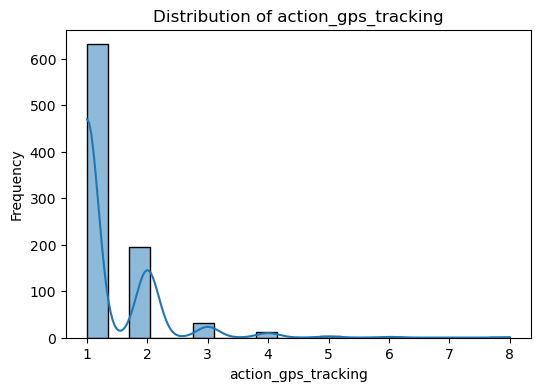

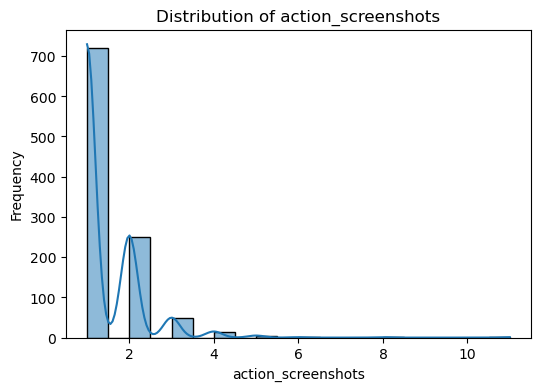

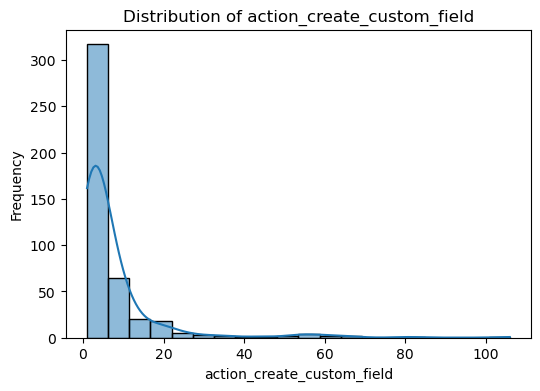

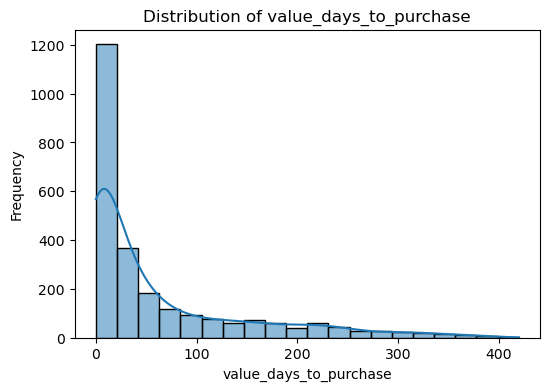

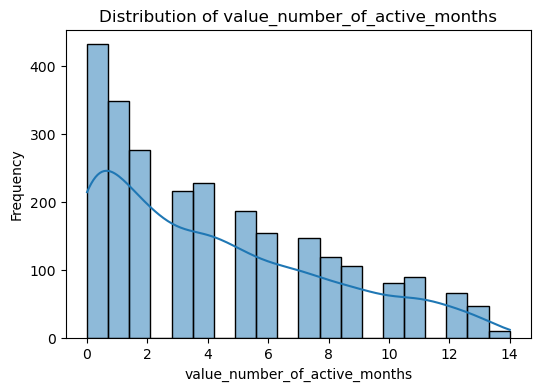

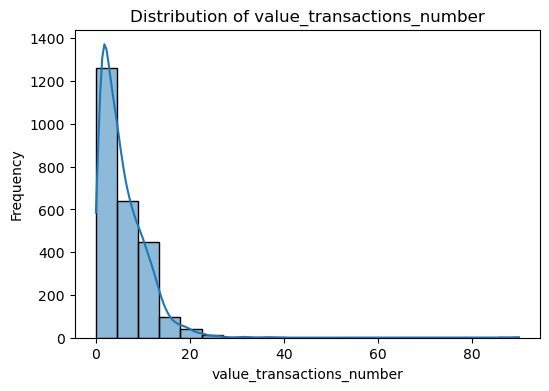

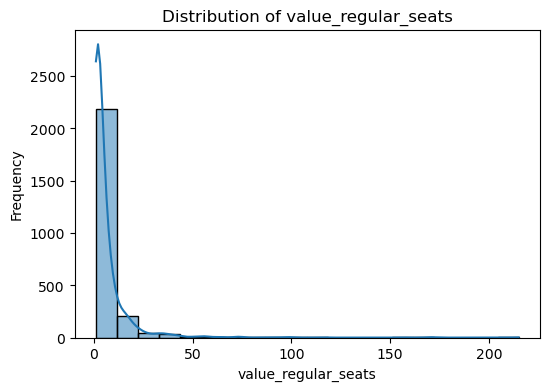

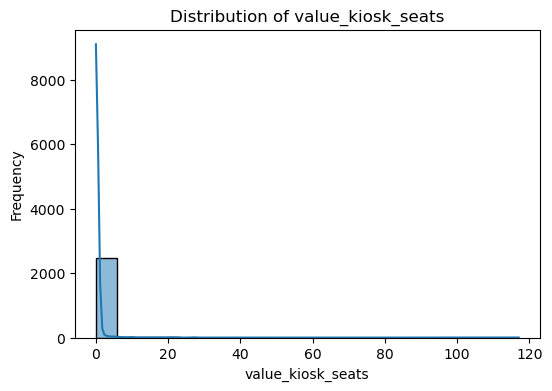

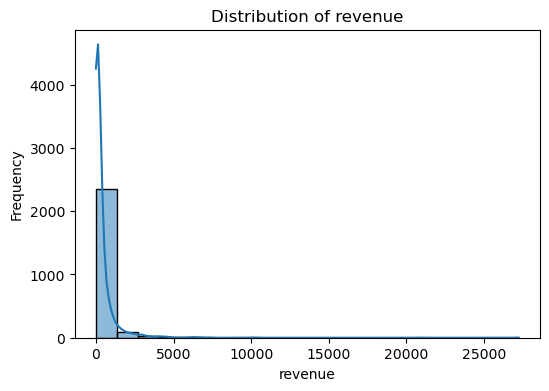

                             Column     Type  Missing Count  Missing %  \
0                ws_users_activated    int64              0   0.000000   
1              ws_users_deactivated    int64              0   0.000000   
2                  ws_users_invited    int64              0   0.000000   
3             action_create_project    int64              0   0.000000   
4              action_export_report    int64              0   0.000000   
5           action_api_and_webhooks    int64              0   0.000000   
6   action_time_entries_via_tracker    int64              0   0.000000   
7                action_start_trial    int64              0   0.000000   
8                 action_import_csv    int64              0   0.000000   
9             action_create_invoice    int64              0   0.000000   
10              action_lock_entries    int64              0   0.000000   
11               action_add_targets    int64              0   0.000000   
12        action_connect_quickbooks   

In [87]:
# Perform statistical analysis
stats_df = basic_statistics(df)
print(stats_df)

# Step 2: Handle Missing Values
### There is no unique way of handling missing values. The best approach depends on the amount of missing data and its impact on the analysis.
### - For a **small number of missing values (<5%)**, replacing missing values with a central tendency measure is effective:
###   - **Mean** for numerical float columns (if data is normally distributed).
###   - **Median** for integer columns (robust to outliers).
###   - **Mode** (most frequent value) for categorical columns.
### - If the percentage of missing values is **higher (5%-50%)**, we can use more sophisticated imputation techniques:
###   - **Sampling from a distribution**: If a column follows a normal distribution, we can sample from the available data using its mean and standard deviation.
###   - **Predictive modeling**: A machine learning model (e.g., Random Forest) can predict missing values using other available data.
### - When a column has **very high missing values (>80%)**, it is often safe to remove it, as it likely provides little useful information.
###   - However, before dropping a column, it's a good practice to check with the client if missing values have a specific meaning (e.g., default values like 0).
### - In this dataset, columns **'action_gps_tracking' (58% missing)** and **'action_screenshots' (65% missing)** are kept, even though they have high missing percentages, as they may still be valuable for predicting churn.
###   We replace missing numerical values with appropriate strategies:
### - Integer columns: Replace missing values with the median, as it is robust to outliers.
### - Float columns: Replace missing values with the mean, as it preserves the overall distribution.
### - Categorical columns: Replace missing values with the most frequent category (mode), assuming that the missing data follows an underlying pattern.

In [88]:
df_cleaned = df.copy()
int_cols = df_cleaned.select_dtypes(include=['int64']).columns
float_cols = df_cleaned.select_dtypes(include=['float64']).columns
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

int_imputer = SimpleImputer(strategy='median')
float_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

df_cleaned[int_cols] = int_imputer.fit_transform(df_cleaned[int_cols])
df_cleaned[float_cols] = float_imputer.fit_transform(df_cleaned[float_cols])
df_cleaned[cat_cols] = cat_imputer.fit_transform(df_cleaned[cat_cols])

# Step 3: Drop columns with over 80% missing values
### If a column has too many missing values, it may not be useful for predictions.

In [89]:
missing_threshold = 80.0  # Percentage threshold
df_cleaned = df_cleaned.dropna(thresh=len(df_cleaned) * (1 - missing_threshold / 100), axis=1)

# Step 4: Encode Categorical Variables
### Machine learning models cannot work directly with categorical variables. 
### We use Label Encoding for 'country', which assigns each unique category a numerical value.
### We also convert 'churned_status' to binary values (Yes -> 1, No -> 0) since it is our target variable.

In [90]:
df_cleaned['churned_status'] = df_cleaned['churned_status'].map({'Yes': 1, 'No': 0})
encoder = LabelEncoder()
df_cleaned['country'] = encoder.fit_transform(df_cleaned['country'])

# Step 5: Split the Dataset
### We split the dataset into training (80%) and testing (20%) sets to evaluate model performance on unseen data.

In [91]:
X = df_cleaned.drop(columns=['churned_status'])
y = df_cleaned['churned_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)

# Step 6: Normalize Numeric Features
### Standardization ensures better performance for models sensitive to scale.
### However, handling integer values requires careful consideration:
### - **Ordinal Variables (e.g., Customer Rank: 1, 2, 3, 4, 5)**: Standardization is useful because their relative positioning matters.
### - **Binary Features (e.g., 0/1 for Yes/No variables)**: Usually, no need to scale them unless required for a specific model.
### - **Count-Based Features (e.g., Number of Logins, Purchases)**: These can have a wide range of values, so standardization helps for models like SVM or Logistic Regression, but it's not necessary for tree-based models like Random Forest or XGBoost.
### - **Tree-based models (Random Forest, XGBoost) do not require scaling**, as they are not sensitive to feature magnitudes.
### In this implementation, we standardize integer values because we are using multiple models, some of which benefit from normalization.

In [92]:
scaler = StandardScaler()
X_train[int_cols] = scaler.fit_transform(X_train[int_cols])
X_test[int_cols] = scaler.transform(X_test[int_cols])
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

# Step 6: Train Multiple Models
### Below is a brief explanation of each model used:
### - **Logistic Regression**: A simple linear model that estimates the probability of churn using a logistic function.
### - **Random Forest**: An ensemble of decision trees that reduces overfitting by averaging multiple tree predictions.
### - **SVM (Support Vector Machine)**: A model that finds the optimal hyperplane to separate churned and non-churned customers.
### - **XGBoost**: A gradient boosting model that iteratively improves weak learners to enhance predictive accuracy.
### - **K-Nearest Neighbors (KNN)**: A non-parametric model that classifies customers based on the majority class among their nearest neighbors.
### - **Gradient Boosting**: An ensemble technique that builds models sequentially, correcting errors in previous iterations.
### - **Bagging (Bootstrap Aggregating)**: An ensemble method that trains multiple base classifiers on random subsets of the data and aggregates their predictions.
### - **Neural Network (MLP Classifier)**: A feedforward neural network with hidden layers that captures complex relationships in the data. This is just the tip of the iceberg when it comes to neural networks. There are infinitely many possibilities for tuning this model, from the number of layers and nodes in each layer, to the activation functions used, regularization methods, and optimization algorithms. More complex architectures could yield better performance depending on the dataset.

In [93]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=89),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=89),
    "SVM": SVC(kernel='linear', probability=True, random_state=89),
    "XGBoost": XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=89),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=89),
    "Bagging": BaggingClassifier(n_estimators=100, random_state=89),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=89)
}

In [94]:
results = []
conf_matrices = {}

# Step 7: Train & Evaluate Models
### The following evaluation metrics are used to assess model performance:
### - **Accuracy**: Measures the overall correctness of predictions. However, it can be misleading when data is imbalanced.
### - **Precision**: The ratio of correctly predicted churned customers to all predicted churned customers. High precision means fewer false positives.
### - **Recall (Sensitivity)**: The ratio of correctly predicted churned customers to all actual churned customers. High recall ensures fewer false negatives.
### - **F1 Score**: The harmonic mean of precision and recall. It provides a balanced measure when dealing with imbalanced datasets.
### - **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**: Measures how well the model distinguishes between churned and non-churned customers.
### - **Confusion Matrix**: A breakdown of correct and incorrect predictions that helps visualize performance.

### **Handling Imbalanced Data:**
### - In real-world churn datasets, the proportion of churned vs. non-churned customers is often imbalanced.
### - In such cases, accuracy alone is not a reliable metric, and more emphasis should be placed on precision, recall, and F1-score.
### - Techniques like resampling (oversampling the minority class or undersampling the majority class) or using weighted loss functions can help mitigate this issue.

In [95]:
for name, model in models.items():
    print('Training model: ', name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1, roc_auc])

print('Models training completed.')

Training model:  Logistic Regression
Training model:  Random Forest
Training model:  SVM


/home/goran/anaconda3/envs/Moj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training model:  XGBoost
Training model:  KNN
Training model:  Gradient Boosting
Training model:  Bagging
Training model:  Neural Network
Models training completed.


# Step 8: Save Results
### The results and performance metrics of each model are saved into a single CSV file for comparison.
### This allows for an easy overview of model performance and helps in selecting the best-performing model.

In [96]:
comparison_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"])
comparison_df.to_csv("model_comparison_results.csv", index=False)
print(comparison_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.720559   0.623853  0.407186  0.492754  0.642216
1        Random Forest  0.748503   0.699029  0.431138  0.533333  0.669162
2                  SVM  0.666667   0.000000  0.000000  0.000000  0.500000
3              XGBoost  0.736527   0.629630  0.508982  0.562914  0.679641
4                  KNN  0.666667   0.500000  0.449102  0.473186  0.612275
5    Gradient Boosting  0.730539   0.660000  0.395210  0.494382  0.646707
6              Bagging  0.726547   0.629310  0.437126  0.515901  0.654192
7       Neural Network  0.678643   0.553571  0.185629  0.278027  0.555389


# Discussion of Results:
### Based on the evaluation metrics, it appears that **XGBoost, Random Forest, and Gradient Boosting** performed the best, achieving higher accuracy, precision, and recall scores. These ensemble methods are known for their ability to handle complex data patterns and reduce overfitting.

### On the other hand, **SVM had the worst performance**, likely due to the nature of the dataset and the fact that
### SVM is sensitive to feature scaling and class imbalance. Other models, including Logistic Regression, KNN, and Bagging, performed somewhere in between, providing useful insights but not achieving the best overall scores.

### Further fine-tuning of hyperparameters could improve the performance of all models. Additionally, balancing the dataset and using more advanced feature engineering techniques may further enhance results.

# Step 9: Visualizing Confusion Matrices
### Confusion matrices provide a simple view of model performance by showing the number of correct and incorrect predictions for each class.
### This visualization helps in understanding how well each model distinguishes between churned and non-churned customers.

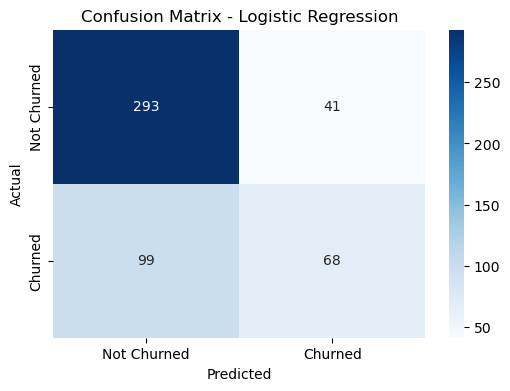

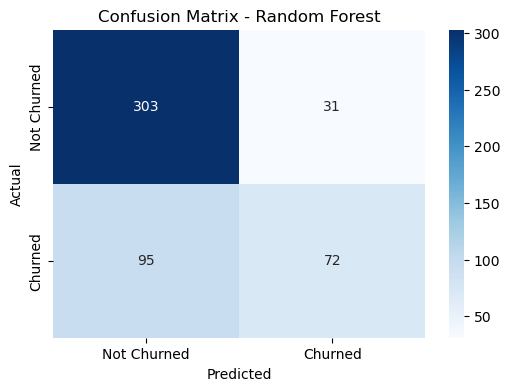

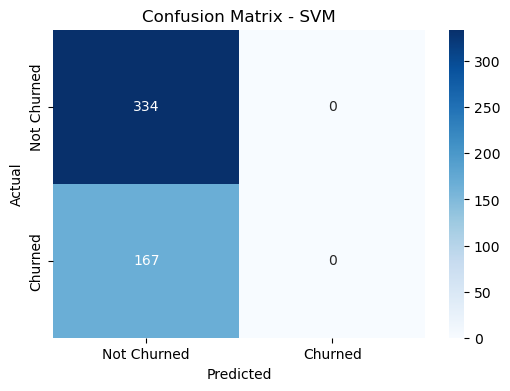

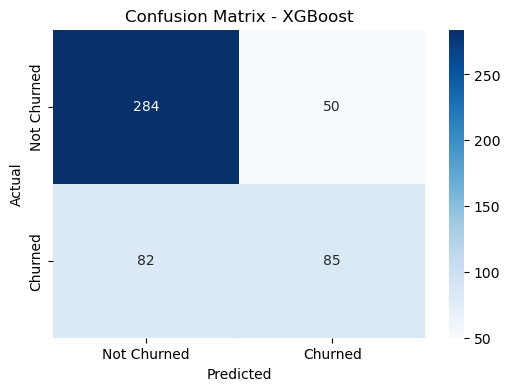

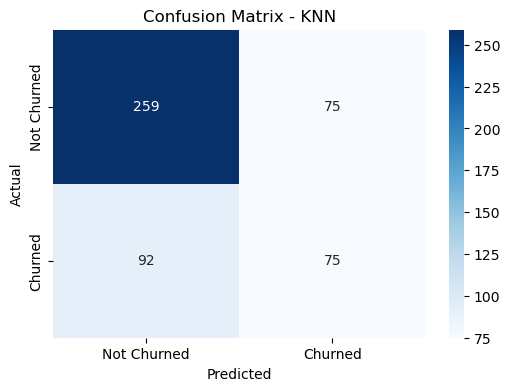

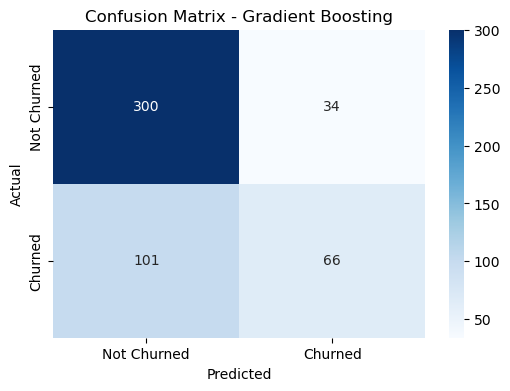

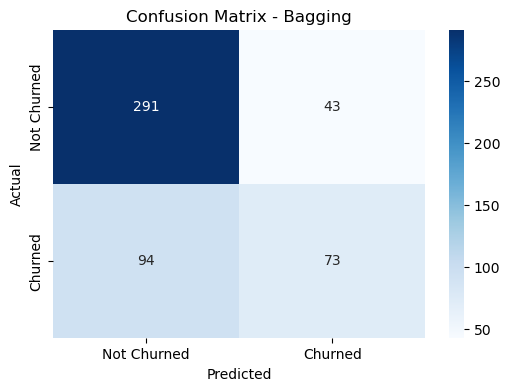

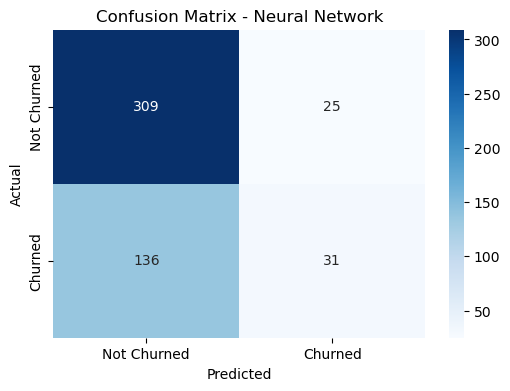

In [97]:
for name, matrix in conf_matrices.items():
    plt.figure(figsize=(6,4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [98]:
print("Churn classification completed. Results saved to 'model_comparison_results.csv'")
print("all done!")

Churn classification completed. Results saved to 'model_comparison_results.csv'
all done!


# Step 10: Summary and Next Steps
### This project provides a structured approach to churn classification using multiple machine learning models. Due to time constraints, a more in-depth analysis, including feature engineering and hyperparameter tuning, was not performed. Additionally, for each method, many of the parameters used were set to their default values. Further optimization of these hyperparameters can lead to improved model performance.


## **Summary of Steps:**
### 1. **Data Exploration**: Performed basic statistical analysis and identified missing values.
### 2. **Data Preprocessing**: Handled missing values, encoded categorical variables, and normalized numerical data.
### 3. **Model Selection**: Trained multiple models, from simple logistic regression to complex ensemble methods and neural networks.
### 4. **Evaluation**: Used multiple performance metrics, including accuracy, precision, recall, and F1-score, with a focus on handling imbalanced data.
### 5. **Comparison**: Saved model performance metrics to a CSV file and visualized confusion matrices for better interpretability.

## **Key Choices Made:**
### - Handled missing values based on column type and percentage of missing data.
### - Used standardization for numerical features to improve model performance.
### - Evaluated models using multiple metrics instead of relying only on accuracy.

## **Limitations and Next Steps:**
### - Many model hyperparameters were left at their default values. Fine-tuning these parameters could significantly enhance performance.
### - This is by no means the best way to handle this task; further fine-tuning of hyperparameters can improve model performance.
### - Feature engineering (e.g., creating new features from existing ones) could enhance predictive power.
### - More advanced sampling techniques (such as SMOTE) could be used to better address class imbalance.
### - Further exploration of deep learning architectures may yield better results compared to traditional machine learning models.

## **Conclusion:**
### This notebook establishes a **baseline** for churn prediction, offering a structured framework for further improvements.
### Future work should focus on optimizing model performance through hyperparameter tuning and additional data preprocessing steps.